# Optimization Dynamics via Induced Kernels

In this notebook, we study how different optimization algorithms induce
**different kernels** that govern the local training dynamics of neural networks.

We compare:
- Gradient Descent (GD)
- Adam
- Adagrad
- Damped Gauss–Newton (Levenberg–Marquardt)

**Key questions:**
- How does each method shape the effective kernel?
- How does kernel conditioning evolve during training?
- Why do second-order methods behave fundamentally differently?


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 1. Parameter-space utilities

To analyze optimization kernels, we need to:
- Flatten parameters into vectors
- Reconstruct parameters from flat vectors
- Compute Jacobians of the network output with respect to parameters

These utilities allow us to work explicitly in parameter space.

In [2]:
def flatten_params(params):
    return torch.cat([p.reshape(-1) for p in params])

def get_param_shapes(params):
    return [p.shape for p in params]

def unflatten_like(vec, shapes):
    outs = []
    idx = 0
    for shp in shapes:
        num = int(np.prod(shp))
        outs.append(vec[idx:idx+num].reshape(shp))
        idx += num
    return outs

## 2. Jacobian and induced kernels

Let $G \in \mathbb{R}^{N \times P}$ denote the Jacobian of the network outputs
with respect to the parameters, evaluated at all data points.

Many optimization methods induce kernels of the form:
\[
K = G M G^\top,
\]
where:
- $M = I$ for Gradient Descent,
- $M$ is diagonal for adaptive methods (Adam, Adagrad),
- $M = (G^\top G + \lambda I)^{-1}$ for Gauss–Newton.

We explicitly construct these kernels below.

In [3]:
def compute_G(model, X):
    params = list(model.parameters())
    N = X.shape[0]
    G_rows = []
    for i in range(N):
        model.zero_grad()
        out = model(X[i:i+1]).sum()
        grads = torch.autograd.grad(out, params, retain_graph=True)
        g_flat = torch.cat([g.reshape(-1) for g in grads])
        G_rows.append(g_flat.detach())
    return torch.stack(G_rows, dim=0).double()  # (N, P)

## 3. Kernel conditioning

We measure conditioning using the ratio of largest to smallest **positive**
eigenvalues of the kernel:
$
\kappa(K) = \frac{\lambda_{\max}}{\lambda_{\min}}.
$

Zero or near-zero eigenvalues are ignored, as they correspond to flat directions.

In [48]:
def cond_number(K):

    # evals = torch.linalg.eigvalsh(K.cpu()).numpy()    
    evals = torch.linalg.svdvals(K.cpu()).numpy()    
    eps = 1e-9
    pos = evals[evals > eps]
    if len(pos) == 0:
        return np.inf, pos
    return pos.max() / pos.min(), pos

## 4. Dataset and neural network

We consider a small regression problem in $\mathbb{R}^2$ with only 20 samples.

This deliberately places us in a **small-data, overparameterized regime**.

The network is intentionally tiny so that kernel computations remain tractable.

In [5]:
def make_dataset(n=20):
    X = np.random.uniform(-1, 1, size=(n, 2))
    y = np.sin(np.pi * X[:, 0]) + np.cos(np.pi * X[:, 1])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def make_fresh_model(seed=0):
    torch.manual_seed(seed)
    return TinyNet()

## 5. Optimization methods

We now compare four optimization strategies:
1. Full-batch Gradient Descent
2. Adam
3. Adagrad
4. Damped Gauss–Newton

For each method, we track:
- Training loss
- Kernel condition number
- Kernel eigenvalue spectrum at a selected iteration

In [6]:
def run_gd(X, y, T=30, lr=1e-2, eig_record_it=10):
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses, conds = [], []
    kernel_eigenvals = None

    for t in range(T):
        optimizer.zero_grad()
        loss = loss_fn(model(X), y)
        loss.backward()
        optimizer.step()

        G = compute_G(model, X)
        K = 1e-2 * G @ G.t()

        cond, eigs = cond_number(K)
        losses.append(loss.item())
        conds.append(cond)

        if t == eig_record_it:
            kernel_eigenvals = eigs

        print(f"[GD] iter {t:02d} | loss={losses[-1]:.2e} | cond={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals

In [25]:
def run_adam(X, y, T=30, lr=1e-3, eps=1e-8, eig_record_it=10):
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set up param ordering for v_flat consistent with flatten_params()
    params = list(model.parameters())
    P = sum(p.numel() for p in params)
    index_map = {}
    offset = 0
    for p in params:
        sz = p.numel()
        index_map[p] = (offset, offset + sz)
        offset += sz

    losses = []
    conds  = []
    kernel_eigenvals = None

    for t in range(T):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Build v_flat from Adam's exp_avg_sq in same order as params list
        v_flat = torch.zeros(P, dtype=torch.float64)
        for p in params:
            state = optimizer.state[p]
            v = state.get('exp_avg_sq', torch.zeros_like(p))
            i0, i1 = index_map[p]
            v_flat[i0:i1] = v.detach().reshape(-1).double()

        # Adam kernel: K_Adam = G D G^T, D diag(lr / (sqrt(v)+eps))
        G = compute_G(model, X)          # (N, P)
        D = torch.diag(lr / (torch.sqrt(v_flat) + eps))
        K_adam = G @ D @ G.t()

        losses.append(loss.item())
        cond, eigenvalues = cond_number(K_adam)
        conds.append(cond)
        if(t == eig_record_it):
            kernel_eigenvals = eigenvalues

        print(f"[Adam]    iter {t:02d} | loss={losses[-1]:.4e} | cond(K_Adam)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals


In [26]:
def run_adagrad(X, y, T=30, lr=1e-2, eps=1e-10, eig_record_it=10):
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr, eps=eps)

    params = list(model.parameters())
    P = sum(p.numel() for p in params)
    index_map = {}
    offset = 0
    for p in params:
        sz = p.numel()
        index_map[p] = (offset, offset + sz)
        offset += sz

    losses = []
    conds  = []

    for t in range(T):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Adagrad state: 'sum' = accumulated squared gradients
        v_flat = torch.zeros(P, dtype=torch.float64)
        for p in params:
            state = optimizer.state[p]
            s = state.get('sum', torch.zeros_like(p))
            i0, i1 = index_map[p]
            v_flat[i0:i1] = s.detach().reshape(-1).double()

        # Adagrad update: θ <- θ - lr * g / (sqrt(sum) + eps)
        # => preconditioner diag ~ lr / (sqrt(sum)+eps)
        G = compute_G(model, X)
        D = torch.diag(lr / (torch.sqrt(v_flat) + eps))
        K_adagrad = G @ D @ G.t()


        losses.append(loss.item())
        cond, eigenvalues = cond_number(K_adagrad)
        conds.append(cond)
        if(t == eig_record_it):
            kernel_eigenvals = eigenvalues


        print(f"[Adagrad] iter {t:02d} | loss={losses[-1]:.4e} | cond(K_Ada)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals


In [ ]:
def run_gauss_newton(X, y, T=20, lr=0.1, lambda_damp=1e-2, eig_record_it=10):
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()

    params = list(model.parameters())
    shapes = get_param_shapes(params)

    losses = []
    conds  = []

    for t in range(T):
        # forward pass
        with torch.no_grad():
            pred = model(X)
        r = (pred - y).double()                         # (N,1)
        loss_val = loss_fn(pred, y).item()

        # Jacobian
        G = compute_G(model, X)                         # (N, P)
        N, P = G.shape

        # Build normal matrix B = G^T G + lambda I
        GT = G.t()                                      # (P, N)
        B = GT @ G + lambda_damp * torch.eye(P, dtype=torch.float64)
        rhs = GT @ r.view(-1, 1)                        # (P, 1)

        # Solve for delta_theta
        delta_theta = -torch.linalg.solve(B, rhs).view(-1)   # (P,)
        
        # older torch versions
        # delta_theta, _ = torch.solve(rhs, B)
        # delta_theta = -delta_theta.view(-1)

        # Update parameters
        with torch.no_grad():
            theta_flat = flatten_params(params).double()
            theta_new = theta_flat + lr*delta_theta
            new_tensors = unflatten_like(theta_new, shapes)
            for p, new_v in zip(params, new_tensors):
                p.copy_(new_v.to(p.dtype))

        # Kernel K_GN = G (G^T G + lambda I)^{-1} G^T
        B_inv = torch.linalg.inv(B)
        
        K_gn = G @ B_inv @ G.t()

        losses.append(loss_val)
        cond, eigenvalues = cond_number(K_gn)
        conds.append(cond)
        if(t == eig_record_it):
            kernel_eigenvals = eigenvalues



        print(f"[GN]      iter {t:02d} | loss={losses[-1]:.4e} | cond(K_GN)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals


In [49]:
X, y = make_dataset(n=20)

loss_gd,   cond_gd,   eig_GD   = run_gd(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_adam, cond_adam, eig_adam = run_adam(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_ada,  cond_ada,  eig_ada  = run_adagrad(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_gn,   cond_gn,   eig_gn   = run_gauss_newton(X, y, T=75, lr=1.0, lambda_damp=1e-1, eig_record_it=30)

[GD] iter 00 | loss=7.88e-01 | cond=1.14e+05
[GD] iter 01 | loss=7.86e-01 | cond=1.14e+05
[GD] iter 02 | loss=7.84e-01 | cond=1.14e+05
[GD] iter 03 | loss=7.82e-01 | cond=1.13e+05
[GD] iter 04 | loss=7.80e-01 | cond=1.13e+05
[GD] iter 05 | loss=7.78e-01 | cond=1.13e+05
[GD] iter 06 | loss=7.76e-01 | cond=1.13e+05
[GD] iter 07 | loss=7.74e-01 | cond=1.13e+05
[GD] iter 08 | loss=7.72e-01 | cond=1.13e+05
[GD] iter 09 | loss=7.71e-01 | cond=1.13e+05
[GD] iter 10 | loss=7.69e-01 | cond=1.13e+05
[GD] iter 11 | loss=7.67e-01 | cond=1.12e+05
[GD] iter 12 | loss=7.65e-01 | cond=1.12e+05
[GD] iter 13 | loss=7.64e-01 | cond=1.12e+05
[GD] iter 14 | loss=7.62e-01 | cond=1.12e+05
[GD] iter 15 | loss=7.60e-01 | cond=1.12e+05
[GD] iter 16 | loss=7.59e-01 | cond=1.12e+05
[GD] iter 17 | loss=7.57e-01 | cond=1.12e+05
[GD] iter 18 | loss=7.56e-01 | cond=1.12e+05
[GD] iter 19 | loss=7.54e-01 | cond=1.11e+05
[GD] iter 20 | loss=7.53e-01 | cond=1.11e+05
[GD] iter 21 | loss=7.51e-01 | cond=1.12e+05
[GD] iter 

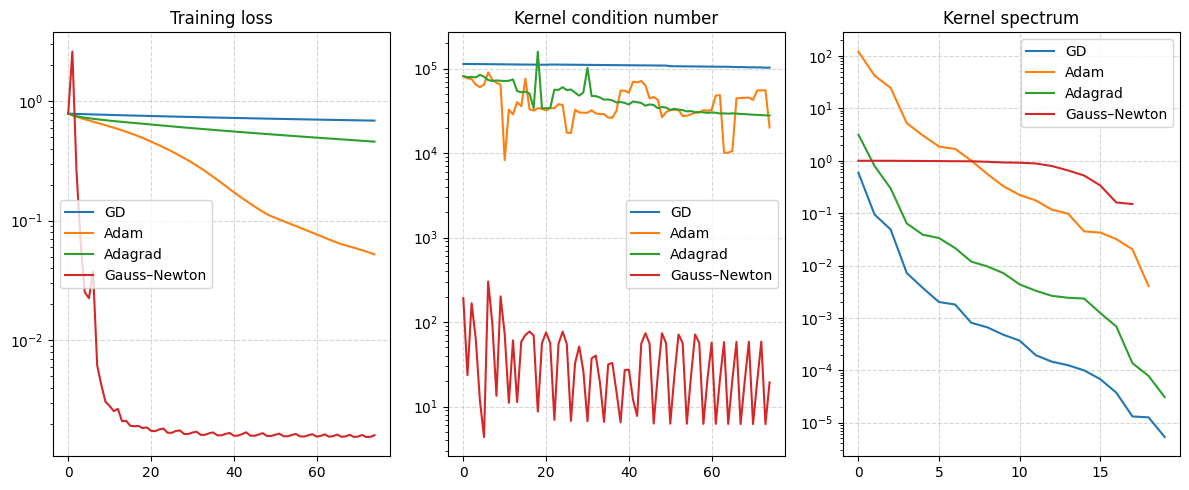

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.semilogy(loss_gd, label="GD")
plt.semilogy(loss_adam, label="Adam")
plt.semilogy(loss_ada, label="Adagrad")
plt.semilogy(loss_gn, label="Gauss–Newton")
plt.title("Training loss")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

plt.subplot(1,3,2)
plt.semilogy(cond_gd, label="GD")
plt.semilogy(cond_adam, label="Adam")
plt.semilogy(cond_ada, label="Adagrad")
plt.semilogy(cond_gn, label="Gauss–Newton")
plt.title("Kernel condition number")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

plt.subplot(1,3,3)
plt.semilogy(eig_GD, label="GD")
plt.semilogy(eig_adam, label="Adam")
plt.semilogy(eig_ada, label="Adagrad")
plt.semilogy(eig_gn, label="Gauss–Newton")
plt.title("Kernel spectrum")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

## 6. Discussion

Key observations:

- **Gradient Descent** induces a poorly conditioned kernel, reflecting raw Jacobian anisotropy.
- **Adam and Adagrad** modify the spectrum through diagonal preconditioning, improving stability but not fully correcting conditioning.
- **Gauss–Newton** produces a dramatically better-conditioned kernel by directly incorporating curvature information.

### Takeaway
Adaptive first-order methods improve optimization dynamics,
but **second-order structure fundamentally reshapes the loss geometry**.
